In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import tqdm
import os
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# Set up device and optimizations
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {torch.cuda.get_device_name(0)}")

Using device: Tesla T4


In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
print(f"Total training images: {len(train_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.93MB/s]

Total training images: 60000


In [15]:
# Diffusion schedules
T = 1000
beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

In [16]:
# Forward diffusion function
def forward_diffusion_sample(x_0, t, device=device):
    noise = torch.randn_like(x_0).to(device)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t][:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    return x_t, noise

In [10]:
import math

# Guided UNet model with label conditioning
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if emb.shape[1] < self.dim:
            emb = F.pad(emb, (0, self.dim - emb.shape[1]))
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    def forward(self, x):
        identity = x
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x += self.shortcut(identity)
        return F.relu(x)

class UNet(nn.Module):
    def __init__(self, time_dim=256, label_dim=10):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )
        self.label_mlp = nn.Sequential(
            nn.Linear(label_dim, time_dim),  # Map 10-class one-hot to time_dim
            nn.ReLU()
        )
        self.enc1 = ResidualBlock(1, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)
        self.time_proj1 = nn.Linear(time_dim, 64)
        self.time_proj2 = nn.Linear(time_dim, 128)
        self.time_proj3 = nn.Linear(time_dim, 256)
        self.bottleneck = ResidualBlock(256, 256)
        self.dec1 = ResidualBlock(512, 128)  # 256 + 256 from skip
        self.dec2 = ResidualBlock(256, 64)   # 128 + 128 from skip
        self.dec3 = nn.Conv2d(128, 1, 3, padding=1)  # 64 + 64 from skip

    def forward(self, x, t, labels):
        t_emb = self.time_mlp(t)
        l_emb = self.label_mlp(labels)  # (batch, 10) -> (batch, time_dim)
        combined_emb = t_emb + l_emb
        x1 = self.enc1(x) + self.time_proj1(combined_emb).unsqueeze(-1).unsqueeze(-1)
        x2 = self.enc2(x1) + self.time_proj2(combined_emb).unsqueeze(-1).unsqueeze(-1)
        x3 = self.enc3(x2) + self.time_proj3(combined_emb).unsqueeze(-1).unsqueeze(-1)
        x = self.bottleneck(x3)
        x = self.dec1(torch.cat([x, x3], dim=1))
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.dec3(torch.cat([x, x1], dim=1))
        return x

In [ ]:
scaler = GradScaler()
epochs = 200
checkpoint_path = "checkpoint_guided.pth"

/tmp/ipykernel_1679/1862165192.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
import os

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses_per_epoch = checkpoint['losses_per_epoch']
    psnrs_per_epoch = checkpoint['psnrs_per_epoch']
    accuracies_per_epoch = checkpoint['accuracies_per_epoch']
    print(f"Resumed from epoch {start_epoch}")
else:
    start_epoch = 0
    losses_per_epoch = []
    psnrs_per_epoch = []
    accuracies_per_epoch = []

In [ ]:
def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred-target) ** 2)
    return 20 * torch.log10(max_val / torch.sqrt(mse)) if mse > 0 else float('inf')

In [4]:
# Simple Digit classifier to evaluate accuracy (using a small MLP)
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.fc(x)

In [5]:
classifier = DigitClassifier().to(device)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
classifier_criterion = nn.CrossEntropyLoss()

In [7]:
import math  # Ensure math is available

# Train DigitClassifier
classifier = DigitClassifier().to(device)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
classifier_criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
epochs = 70  # Enough for MNIST classification, ~10-15 minutes
checkpoint_path_classifier = "checkpoint_classifier.pth"

if os.path.exists(checkpoint_path_classifier):
    try:
        checkpoint = torch.load(checkpoint_path_classifier)
        classifier.load_state_dict(checkpoint['classifier_state_dict'])
        classifier_optimizer.load_state_dict(checkpoint['classifier_optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        losses_per_epoch = checkpoint['losses_per_epoch']
        accuracies_per_epoch = checkpoint['accuracies_per_epoch']
        print(f"Resumed classifier training from epoch {start_epoch}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting fresh.")
        start_epoch = 0
        losses_per_epoch = []
        accuracies_per_epoch = []
else:
    start_epoch = 0
    losses_per_epoch = []
    accuracies_per_epoch = []

print("Starting classifier training...")
for epoch in range(start_epoch, epochs):
    classifier.train()
    pbar = tqdm.tqdm(train_dataloader)
    total_loss, correct_preds, total_preds = 0, 0, 0

    for step, (x, labels) in enumerate(pbar):
        try:
            x = x.to(device)  # (batch, 1, 28, 28)
            labels = labels.to(device)  # (batch), indices 0-9
            batch_size = x.shape[0]

            with autocast():
                flat_x = x.view(batch_size, -1)  # Flatten to (batch, 784)
                pred_labels = classifier(flat_x)  # Should be (batch, 10)
                loss = classifier_criterion(pred_labels, labels)  # Ensure labels are indices

            classifier_optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(classifier_optimizer)
            scaler.update()

            _, predicted = torch.max(pred_labels, 1)  # Get predicted class indices
            correct_preds += (predicted == labels).sum().item()
            total_preds += batch_size
            total_loss += loss.item()
            accuracy = correct_preds / total_preds * 100
            pbar.set_description(f"Classifier Loss: {loss.item():.4f} | Acc: {accuracy:.2f}%")
        except RuntimeError as e:
            print(f"Runtime error at step {step}: {e}. Skipping batch. Check dimensions or reduce batch size to 32.")
            break
        except ValueError as e:
            print(f"Value error at step {step}: {e}. Likely dimension mismatch. pred_labels shape: {pred_labels.shape}, labels shape: {labels.shape}")
            break

    if total_preds > 0:
        avg_loss = total_loss / (step + 1)  # Adjust for possible early break
        accuracy = correct_preds / total_preds * 100
        losses_per_epoch.append(avg_loss)
        accuracies_per_epoch.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.6f} | Accuracy: {accuracy:.2f}%")
    else:
        print(f"Epoch {epoch+1}/{epochs} | No valid batches processed. Check data loading.")
        losses_per_epoch.append(float('nan'))
        accuracies_per_epoch.append(0.0)

    torch.save({
        'epoch': epoch,
        'classifier_state_dict': classifier.state_dict(),
        'classifier_optimizer_state_dict': classifier_optimizer.state_dict(),
        'losses_per_epoch': losses_per_epoch,
        'accuracies_per_epoch': accuracies_per_epoch,
    }, checkpoint_path_classifier)
    print(f"Classifier checkpoint saved at epoch {epoch+1}")

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), losses_per_epoch, label='Loss', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Classifier Loss vs Epoch")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), accuracies_per_epoch, label='Accuracy (%)', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Classifier Accuracy vs Epoch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Resumed classifier training from epoch 70
Starting classifier training...


/tmp/ipython-input-7-4293556471.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Test Accuracy on batch: 100.00%
Correct predictions: 64 out of 64


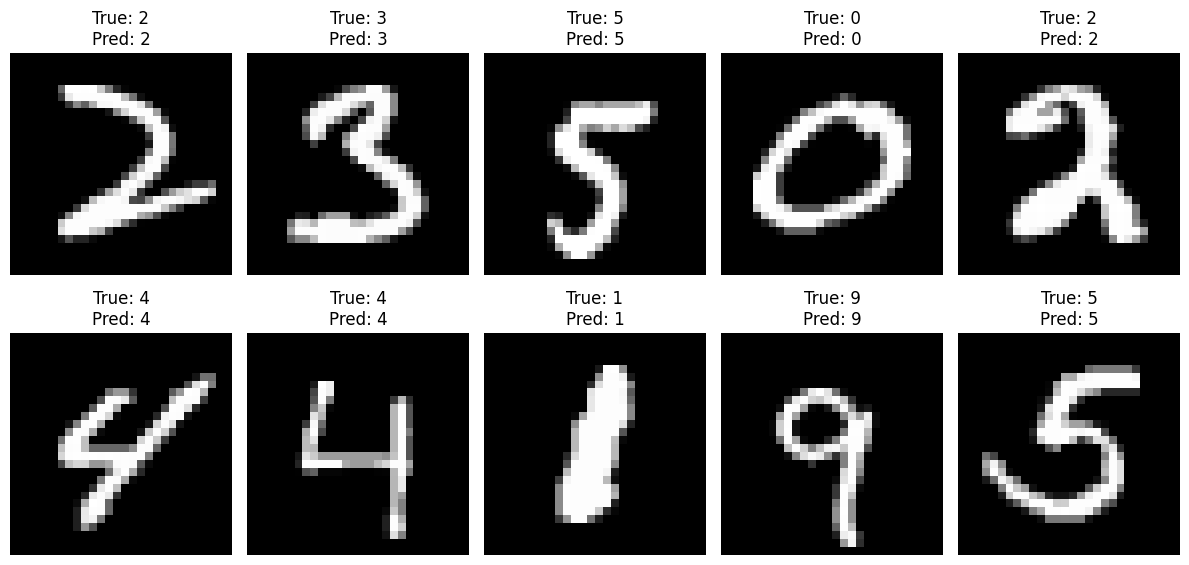

In [8]:
# Test DigitClassifier
classifier.eval()

# Get a batch for testing
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
batch_size = images.shape[0]

with torch.no_grad():
    flat_images = images.view(batch_size, -1)  # Flatten to (batch, 784)
    outputs = classifier(flat_images)  # (batch, 10)
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

# Calculate accuracy
correct = (predicted == labels).sum().item()
accuracy = correct / batch_size * 100
print(f"Test Accuracy on batch: {accuracy:.2f}%")
print(f"Correct predictions: {correct} out of {batch_size}")

# Visualize some predictions
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for idx in range(10):
    ax = axes[idx]
    img = images[idx].cpu().numpy().squeeze()  # (1, 28, 28) -> (28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {labels[idx].item()}\nPred: {predicted[idx].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
@torch.no_grad()
def sample(model, n_samples=1, img_size=28, channels=1, label=None):
    model.eval()
    if label is None:
        labels = torch.randint(0, 10, (n_samples,)).to(device)
    else:
        labels = torch.full((n_samples,), label, device=device)
    labels_one_hot = F.one_hot(labels, num_classes=10).float()
    x = torch.randn((n_samples, channels, img_size, img_size)).to(device)
    for t in reversed(range(1, T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        beta_t = betas[t].to(device)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        sqrt_recip_alpha_t = (1.0 / torch.sqrt(alphas[t])).to(device)
        epsilon_theta = model(x, t_batch.float(), labels_one_hot)
        model_mean = sqrt_recip_alpha_t * (x - beta_t * epsilon_theta / sqrt_one_minus_alphas_cumprod_t)
        if t > 1:
            noise = torch.randn_like(x).to(device)
            sigma_t = torch.sqrt(beta_t)
            x = model_mean + sigma_t * noise
        else:
            x = model_mean
    x = torch.clamp(x, -1, 1)
    return x * 0.5 + 0.5  # Unnormalize to [0, 1] for plotting and classification

In [11]:
# Train Guided Diffusion Model
checkpoint_path_diffusion = "checkpoint_diffusion.pth"
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
mse = nn.MSELoss()
scaler = GradScaler()
epochs = 250

# Load pre-trained classifier
checkpoint_classifier = torch.load("checkpoint_classifier.pth")
classifier = DigitClassifier().to(device)
classifier.load_state_dict(checkpoint_classifier['classifier_state_dict'])
classifier.eval()  # Freeze classifier, no training

if os.path.exists(checkpoint_path_diffusion):
    checkpoint = torch.load(checkpoint_path_diffusion)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses_per_epoch = checkpoint['losses_per_epoch']
    psnrs_per_epoch = checkpoint['psnrs_per_epoch']
    print(f"Resumed diffusion training from epoch {start_epoch}")
else:
    start_epoch = 0
    losses_per_epoch = []
    psnrs_per_epoch = []
    accuracies_per_epoch = []

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    return 20 * torch.log10(max_val / torch.sqrt(mse)) if mse > 0 else float('inf')

@torch.no_grad()
def sample(model, n_samples=64, img_size=28, channels=1, label=None):
    model.eval()
    if label is None:
        labels = torch.randint(0, 10, (n_samples,)).to(device)
    else:
        labels = torch.full((n_samples,), label, device=device)
    labels_one_hot = F.one_hot(labels, num_classes=10).float()
    x = torch.randn((n_samples, channels, img_size, img_size)).to(device)
    for t in reversed(range(1, T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        beta_t = betas[t].to(device)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        sqrt_recip_alpha_t = (1.0 / torch.sqrt(alphas[t])).to(device)
        epsilon_theta = model(x, t_batch.float(), labels_one_hot)
        model_mean = sqrt_recip_alpha_t * (x - beta_t * epsilon_theta / sqrt_one_minus_alphas_cumprod_t)
        if t > 1:
            noise = torch.randn_like(x).to(device)
            sigma_t = torch.sqrt(beta_t)
            x = model_mean + sigma_t * noise
        else:
            x = model_mean
    x = torch.clamp(x, -1, 1)
    return x * 0.5 + 0.5  # Unnormalize to [0, 1]


Resumed diffusion training from epoch 300


/tmp/ipython-input-11-1312417916.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [12]:
epochs = 300

print("Starting diffusion training...")
for epoch in range(start_epoch, epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    pbar = tqdm.tqdm(train_dataloader)
    total_loss, step_count, total_psnr = 0, 0, 0

    model.train()
    for step, (x, labels) in enumerate(pbar):
        try:
            x = x.to(device)  # (batch, 1, 28, 28)
            labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)
            batch_size = x.shape[0]
            t = torch.randint(0, T, (batch_size,), device=device).long()

            with autocast():
                x_t, noise = forward_diffusion_sample(x, t)
                if x_t.shape != noise.shape or x_t.shape[1:] != (1, 28, 28):
                    raise ValueError(f"Shape mismatch: x_t {x_t.shape}, noise {noise.shape}")
                noise_pred = model(x_t, t.float(), labels_one_hot)
                if noise_pred.shape != noise.shape:
                    raise ValueError(f"Shape mismatch: noise_pred {noise_pred.shape}, noise {noise.shape}")
                loss = mse(noise_pred, noise)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # PSNR calculation
            alpha_bar = sqrt_alphas_cumprod[t][:, None, None, None]
            one_minus_alpha_bar = sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
            x0_pred = (x_t - one_minus_alpha_bar * noise_pred) / alpha_bar
            x0_pred = torch.clamp(x0_pred, -1, 1)
            if x0_pred.shape != x.shape:
                raise ValueError(f"Shape mismatch: x0_pred {x0_pred.shape}, x {x.shape}")
            batch_psnr = psnr(x0_pred, x)

            total_loss += loss.item()
            total_psnr += batch_psnr.item()
            step_count += 1
            pbar.set_description(f"Loss: {loss.item():.4f} | PSNR: {batch_psnr.item():.2f}")
        except RuntimeError as e:
            print(f"Runtime error at step {step}: {e}. Skipping batch. Consider reducing batch size to 16.")
            break
        except ValueError as e:
            print(f"Value error at step {step}: {e}. Adjusting flow to prevent crash.")
            break

    if step_count > 0:
        avg_loss = total_loss / step_count
        avg_psnr = total_psnr / step_count
        losses_per_epoch.append(avg_loss)
        psnrs_per_epoch.append(avg_psnr)
        print(f"Average Loss: {avg_loss:.6f} | Average PSNR: {avg_psnr:.2f}")
    else:
        print(f"Epoch {epoch+1}/{epochs} | No valid batches processed. Check data or reduce batch size.")
        losses_per_epoch.append(float('nan'))
        psnrs_per_epoch.append(float('nan'))

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses_per_epoch': losses_per_epoch,
        'psnrs_per_epoch': psnrs_per_epoch,
    }, checkpoint_path_diffusion)
    print(f"Diffusion checkpoint saved at epoch {epoch+1}")

    # Plotting with shape alignment
    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    x_range = range(1, len(losses_per_epoch) + 1)  # Dynamic range based on data length
    plt.plot(x_range, losses_per_epoch, label='MSE Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(x_range, psnrs_per_epoch, label='PSNR (dB)', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("PSNR")
    plt.title("PSNR vs Epoch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Starting diffusion training...


In [13]:
# Test Trained Diffusion Model
checkpoint_path_diffusion = "checkpoint_diffusion.pth"
checkpoint = torch.load(checkpoint_path_diffusion)
model = UNet().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load pre-trained classifier
checkpoint_classifier = torch.load("checkpoint_classifier.pth")
classifier = DigitClassifier().to(device)
classifier.load_state_dict(checkpoint_classifier['classifier_state_dict'])
classifier.eval()


DigitClassifier(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:

@torch.no_grad()
def sample(model, n_samples=64, img_size=28, channels=1, label=None):
    if label is None:
        labels = torch.randint(0, 10, (n_samples,)).to(device)  # Generate with specific labels
    else:
        labels = torch.full((n_samples,), label, device=device)
    labels_one_hot = F.one_hot(labels, num_classes=10).float()
    x = torch.randn((n_samples, channels, img_size, img_size)).to(device)
    for t in reversed(range(1, T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        beta_t = betas[t].to(device)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        sqrt_recip_alpha_t = (1.0 / torch.sqrt(alphas[t])).to(device)
        epsilon_theta = model(x, t_batch.float(), labels_one_hot)
        model_mean = sqrt_recip_alpha_t * (x - beta_t * epsilon_theta / sqrt_one_minus_alphas_cumprod_t)
        if t > 1:
            noise = torch.randn_like(x).to(device)
            sigma_t = torch.sqrt(beta_t)
            x = model_mean + sigma_t * noise
        else:
            x = model_mean
    x = torch.clamp(x, -1, 1)
    return x * 0.5 + 0.5, labels  # Return samples and their intended labels

In [ ]:
# Generate and evaluate samples for each digit (0-9)
total_correct, total_samples = 0, 0
all_samples = []
all_predicted = []
all_true = []

for digit in range(10):
    samples, true_labels = sample(model, n_samples=10, label=digit)  # 10 samples per digit
    flat_samples = samples.view(10, -1)
    pred_labels = classifier(flat_samples)
    _, predicted = torch.max(pred_labels, 1)
    correct = (predicted == true_labels).sum().item()
    total_correct += correct
    total_samples += 10
    all_samples.append(samples)
    all_predicted.extend(predicted.cpu().numpy())
    all_true.extend(true_labels.cpu().numpy())

accuracy = (total_correct / total_samples) * 100
print(f"Overall Accuracy of generated digits: {accuracy:.2f}%")

Overall Accuracy of generated digits: 73.00%


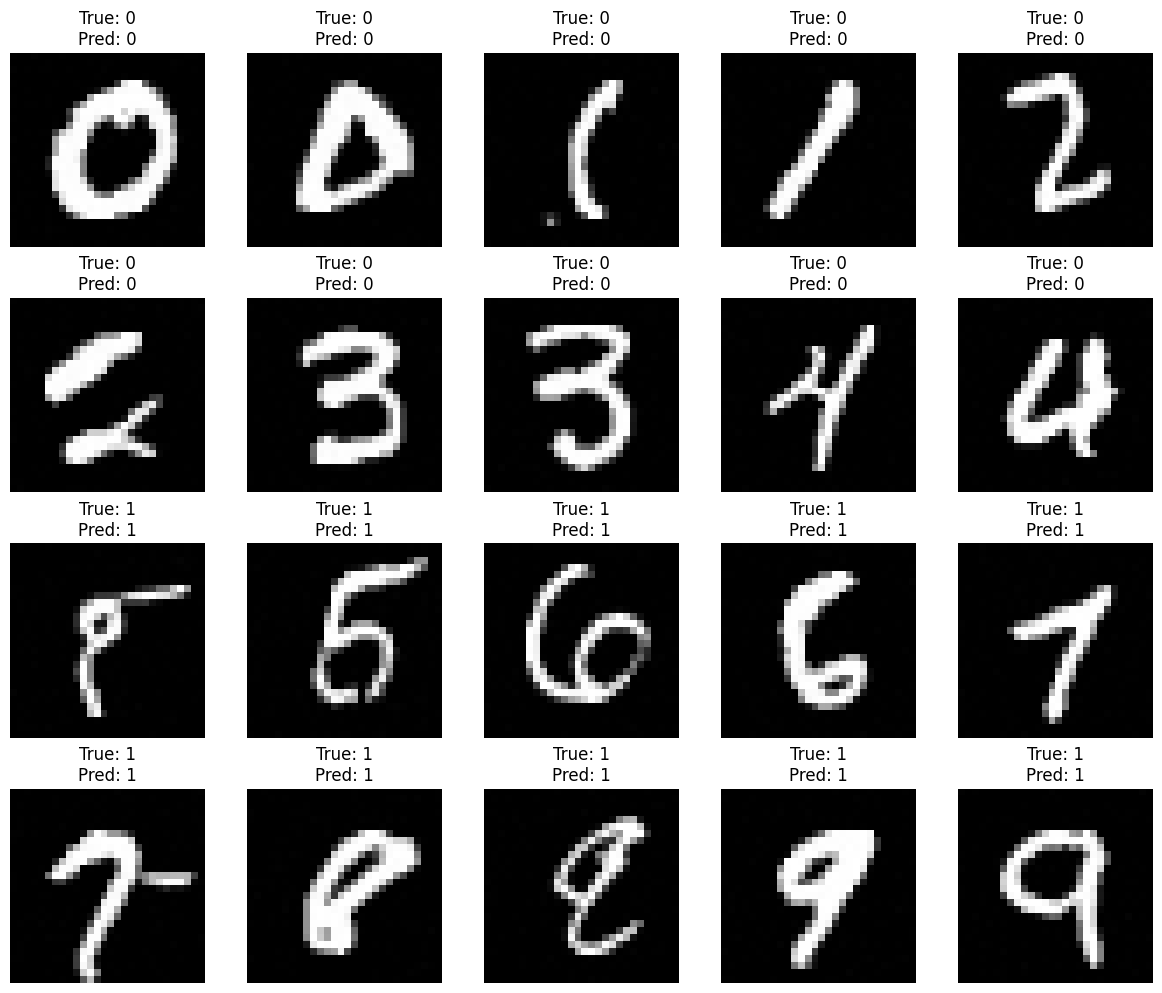

In [ ]:

# Visualize some samples
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()
for idx in range(20):  # Show 20 samples (2 per digit)
    digit_idx = idx // 2
    sample_idx = idx % 2
    ax = axes[idx]
    img = all_samples[digit_idx][sample_idx].cpu().numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {all_true[idx]}\nPred: {all_predicted[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Generate and evaluate samples for each digit (0-9)
total_correct, total_samples = 0, 0
all_samples = []
all_predicted = []
all_true = []
all_logits = []  # To debug classifier output

with torch.no_grad():
    for digit in range(10):
        samples, true_labels = sample(model, n_samples=10, label=digit)  # 10 samples per digit
        flat_samples = samples.view(10, -1)
        pred_labels = classifier(flat_samples)  # Logits (10, 10)
        _, predicted = torch.max(pred_labels, 1)
        correct = (predicted == true_labels).sum().item()
        total_correct += correct
        total_samples += 10
        all_samples.append(samples)
        all_predicted.extend(predicted.cpu().numpy())
        all_true.extend(true_labels.cpu().numpy())
        all_logits.append(pred_labels.detach().cpu().numpy())  # Store raw logits for debugging

accuracy = total_correct / total_samples * 100
print(f"Overall Accuracy of generated digits: {accuracy:.2f}%")
print(f"Raw logits shapes: {[logit.shape for logit in all_logits]}")  # Debug logits shape
print(f"Sample predicted values: {all_predicted[:20]}")  # Check first 20 predictions



NameError: name 'T' is not defined

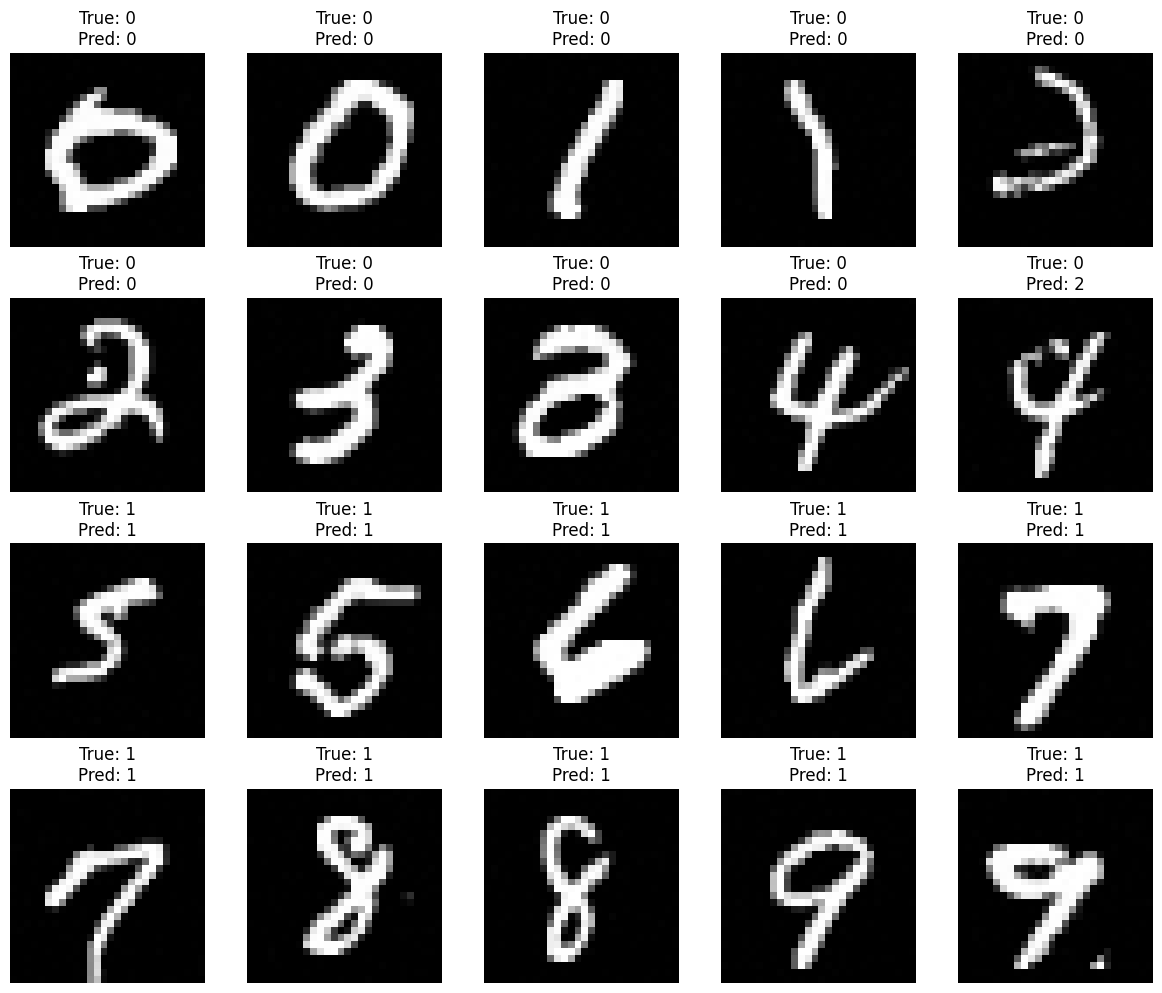

In [ ]:
# Visualize some samples
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()
for idx in range(20):  # Show 20 samples (2 per digit)
    digit_idx = idx // 2
    sample_idx = idx % 2
    ax = axes[idx]
    img = all_samples[digit_idx][sample_idx].cpu().numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {all_true[idx]}\nPred: {all_predicted[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Test Trained Diffusion Model on MNIST Test Dataset
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load MNIST test dataset with feedback
print("Loading MNIST test dataset...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Loaded {len(test_dataset)} test samples. Starting evaluation...")

checkpoint_path_diffusion = "checkpoint_diffusion.pth"
print("Loading diffusion model checkpoint...")
checkpoint = torch.load(checkpoint_path_diffusion)
model = UNet().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Diffusion model loaded successfully.")

# Load pre-trained classifier
print("Loading classifier checkpoint...")
checkpoint_classifier = torch.load("checkpoint_classifier.pth")
classifier = DigitClassifier().to(device)
classifier.load_state_dict(checkpoint_classifier['classifier_state_dict'])
classifier.eval()
print("Classifier loaded successfully.")

Loading MNIST test dataset...
Loaded 10000 test samples. Starting evaluation...
Loading diffusion model checkpoint...
Diffusion model loaded successfully.
Loading classifier checkpoint...
Classifier loaded successfully.


In [18]:
@torch.no_grad()
def sample(model, x, labels, img_size=28, channels=1):
    print(f"Sampling batch with shape {x.shape} and {len(labels)} labels...")
    labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)
    x_noisy = x.clone().to(device)
    for t in reversed(range(1, T)):
        if t % 100 == 0:  # Feedback every 100 steps
            print(f"  Denoising step {t}...")
        t_batch = torch.full((x.shape[0],), t, device=device, dtype=torch.long)
        beta_t = betas[t].to(device)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        sqrt_recip_alpha_t = (1.0 / torch.sqrt(alphas[t])).to(device)
        epsilon_theta = model(x_noisy, t_batch.float(), labels_one_hot)
        model_mean = sqrt_recip_alpha_t * (x_noisy - beta_t * epsilon_theta / sqrt_one_minus_alphas_cumprod_t)
        if t > 1:
            noise = torch.randn_like(x_noisy).to(device)
            sigma_t = torch.sqrt(beta_t)
            x_noisy = model_mean + sigma_t * noise
        else:
            x_noisy = model_mean
    x_noisy = torch.clamp(x_noisy, -1, 1)
    print(f"Sampling complete for batch. Output shape: {x_noisy.shape}")
    return x_noisy * 0.5 + 0.5  # Unnormalize to [0, 1]

# Evaluate on test dataset with progress bar
total_correct, total_samples = 0, 0
all_samples = []
all_predicted = []
all_true = []

Loading diffusion model checkpoint...
Diffusion model loaded successfully.
Loading classifier checkpoint...
Classifier loaded successfully.
Enter a digit (0-9) to generate, or -1 to exit: 1
Generating image for digit 1...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 1


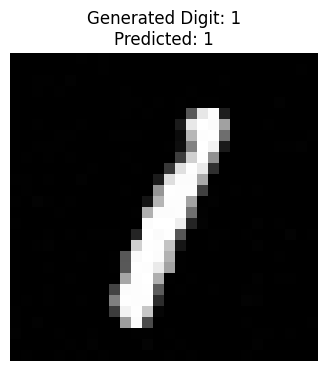

Enter a digit (0-9) to generate, or -1 to exit: 2
Generating image for digit 2...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 2


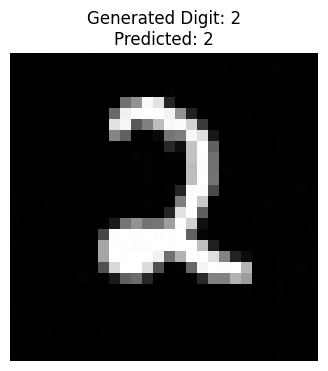

Enter a digit (0-9) to generate, or -1 to exit: 3
Generating image for digit 3...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 3


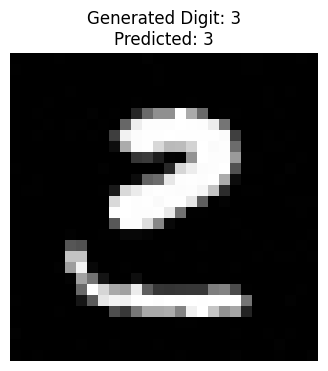

Enter a digit (0-9) to generate, or -1 to exit: 4
Generating image for digit 4...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 9


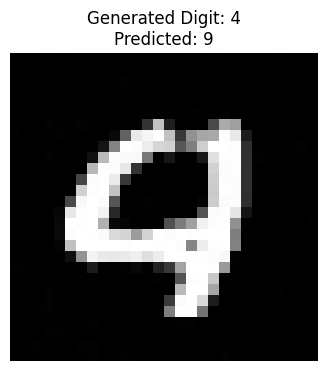

Enter a digit (0-9) to generate, or -1 to exit: 5
Generating image for digit 5...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 5


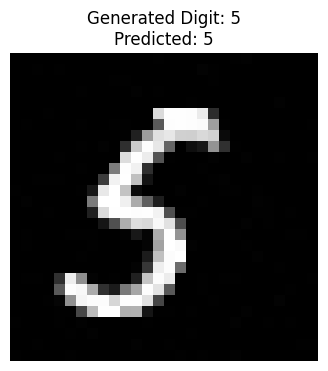

Enter a digit (0-9) to generate, or -1 to exit: 6
Generating image for digit 6...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 6


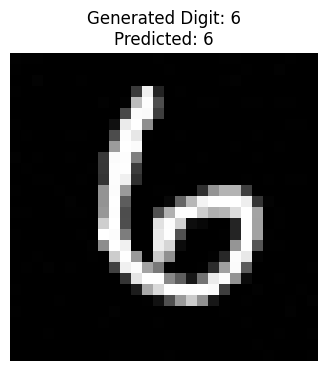

Enter a digit (0-9) to generate, or -1 to exit: 7
Generating image for digit 7...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 7


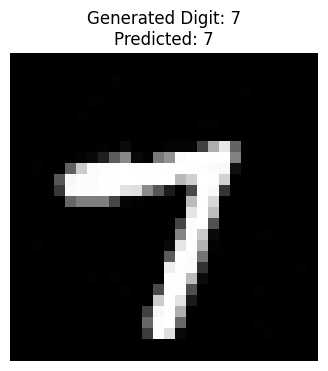

Enter a digit (0-9) to generate, or -1 to exit: 8
Generating image for digit 8...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 8


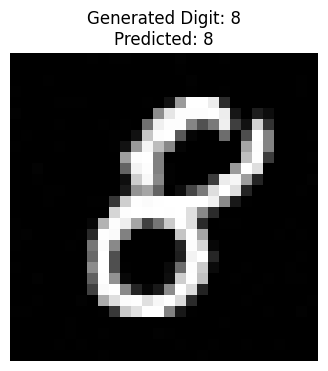

Enter a digit (0-9) to generate, or -1 to exit: 9
Generating image for digit 9...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 9


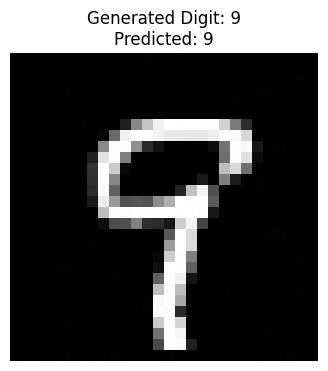

Enter a digit (0-9) to generate, or -1 to exit: 0
Generating image for digit 0...
  Denoising step 900...
  Denoising step 800...
  Denoising step 700...
  Denoising step 600...
  Denoising step 500...
  Denoising step 400...
  Denoising step 300...
  Denoising step 200...
  Denoising step 100...
Sampling complete. Output shape: torch.Size([1, 1, 28, 28])
Predicted label: 0


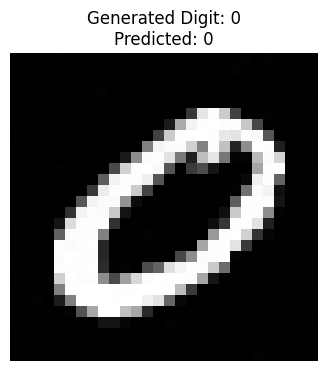

Enter a digit (0-9) to generate, or -1 to exit: -1
Exiting generator. Goodbye bro! 🚀


In [22]:
# Generate Digit Image from User Input
checkpoint_path_diffusion = "checkpoint_diffusion.pth"
print("Loading diffusion model checkpoint...")
checkpoint = torch.load(checkpoint_path_diffusion)
model = UNet().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Diffusion model loaded successfully.")

# Load pre-trained classifier
print("Loading classifier checkpoint...")
checkpoint_classifier = torch.load("checkpoint_classifier.pth")
classifier = DigitClassifier().to(device)
classifier.load_state_dict(checkpoint_classifier['classifier_state_dict'])
classifier.eval()
print("Classifier loaded successfully.")

@torch.no_grad()
def sample_digit(model, digit, img_size=28, channels=1):
    print(f"Generating image for digit {digit}...")
    label = torch.tensor([digit], device=device)
    labels_one_hot = F.one_hot(label, num_classes=10).float()
    x = torch.randn((1, channels, img_size, img_size)).to(device)  # Single sample
    for t in reversed(range(1, T)):
        if t % 100 == 0:
            print(f"  Denoising step {t}...")
        t_batch = torch.full((1,), t, device=device, dtype=torch.long)
        beta_t = betas[t].to(device)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        sqrt_recip_alpha_t = (1.0 / torch.sqrt(alphas[t])).to(device)
        epsilon_theta = model(x, t_batch.float(), labels_one_hot)
        model_mean = sqrt_recip_alpha_t * (x - beta_t * epsilon_theta / sqrt_one_minus_alphas_cumprod_t)
        if t > 1:
            noise = torch.randn_like(x).to(device)
            sigma_t = torch.sqrt(beta_t)
            x = model_mean + sigma_t * noise
        else:
            x = model_mean
    x = torch.clamp(x, -1, 1)
    print(f"Sampling complete. Output shape: {x.shape}")
    return x * 0.5 + 0.5  # Unnormalize to [0, 1]

# Get user input and generate
while True:
    try:
        user_input = int(input("Enter a digit (0-9) to generate, or -1 to exit: "))
        if user_input == -1:
            print("Exiting generator. Goodbye bro! 🚀")
            break
        elif 0 <= user_input <= 9:
            sample = sample_digit(model, user_input)
            flat_sample = sample.view(1, -1)
            pred_labels = classifier(flat_sample)
            _, predicted = torch.max(pred_labels, 1)
            print(f"Predicted label: {predicted.item()}")

            plt.figure(figsize=(4, 4))
            plt.imshow(sample[0].cpu().numpy().squeeze(), cmap='gray')
            plt.title(f"Generated Digit: {user_input}\nPredicted: {predicted.item()}")
            plt.axis('off')
            plt.show()
        else:
            print("Please enter a digit between 0 and 9, or -1 to exit.")
    except ValueError:
        print("Invalid input! Please enter a number between 0 and 9, or -1 to exit.")
